# Interest Rate Derivative Pricing Platform

Team: Hongfei Ge, Sijie Hou, Shuwen Pang

---------------

In this project, we are aiming to deveop a platform for options on interest rates using both BDT and Vasicek models. We start from getting historical data of weekly Treasury yield of past 10 years; interpolation and bootstrapping in order to get spot rate curve ready for further analysis. We choose to value swaptions by analytic and simulation methods of **Vasicek model** as well as **BDT model** with monthly steps. Lastly, we compare the different pricing results and provide recommendations. 

- overview diagram
![structure](./structure.png)

In [1]:
# import standard modules here
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

----------
## 0. Data Preparation

- data source: https://fred.stlouisfed.org/categories/115?t=weekly&rt=weekly&ob=pv&od=desc

Downloaded CMT weekly data of past 10 years with maturities 1-month, 3-month, 6-month, 1-year, 2-year, 3-year, 5-year, 7-year, 10-year, 20-year, and 30-year; merged data sets

In [2]:
# see details in './data/CMT/CMT/preparation.ipynb'
# results are saved in './data/CMT/CMT/CMT.csv'
CMT = pd.read_csv('./data/CMT/CMT/CMT.csv')
CMT.head()

,DATE,1m,3m,6m,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
0,2011-03-25,0.05,0.09,0.16,0.26,0.71,1.17,2.10,2.78,3.38,4.22,4.46
1,2011-04-01,0.04,0.09,0.17,0.30,0.80,1.30,2.23,2.90,3.47,4.29,4.51
2,2011-04-08,0.03,0.05,0.13,0.27,0.82,1.32,2.28,2.95,3.54,4.35,4.57
3,2011-04-15,0.03,0.06,0.12,0.24,0.77,1.27,2.22,2.88,3.51,4.33,4.55
4,2011-04-22,0.04,0.06,0.11,0.24,0.69,1.15,2.12,2.78,3.41,4.23,4.46


--------
## 1. Installment 1

We designed a seires classes to deal with curve bootstraping and interpolation. The structure are shown in the below image. We implemented **Cubic Spline** and **Nelson Siegel** methods to interplate all kinds of curves with any time intervals we prefer.

In this project, we first generate forward curve from par curve and then use forwad curve to get spot curve.

![Curve](./Curves.png)

In [3]:
from src import IRModel
from src import Curves

           0.083333   0.250000  0.500000  1.000000  2.000000  3.000000   \
DATE                                                                      
2011-03-25      0.05  0.0900015  0.160015  0.260078  0.711712   1.17735   
2011-04-01      0.04  0.0900019  0.170019  0.300114  0.802165   1.30897   
2011-04-08      0.03  0.0500004  0.130014  0.270109  0.822435   1.32934   
2011-04-15      0.03  0.0600008   0.12001  0.240082  0.772184   1.27887   
2011-04-22      0.04  0.0600005  0.110007  0.240086  0.691685   1.15725   

           5.000000  7.000000  10.000000 20.000000 30.000000  
DATE                                                          
2011-03-25   2.13866   2.86887   3.53992    4.5692   4.90212  
2011-04-01   2.27197   2.99291    3.6302   4.63679   4.93453  
2011-04-08   2.32428    3.0459   3.70785   4.70257   5.00215  
2011-04-15    2.2626   2.97224   3.68107   4.68727    4.9848  
2011-04-22   2.16042   2.86866   3.57557   4.57708    4.8913  


<AxesSubplot:xlabel='DATE'>

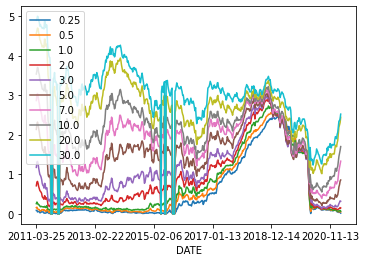

In [4]:
# spot curve bootstrap
spot = IRModel.BondOptionPricer.spotBootstrapping(CMT)
spot.to_csv("./csv_results/installment1_spot_curve.csv")
print(spot.head())
spot.iloc[:,1:].plot()

-------
## 2. Installmet 2

### 2.1 Monthly spot curve interpolation

#### 2.1.1 Cubic Method

Below we displayed results of **Cubic Spline method** and **Nelson Siegel method**.
For Cubic Spline: we divide original yields into three buckets, each with the model formula
<div class="math">
\begin{equation}
  y = a+bt+ct^2+dt^3 
\end{equation}
</div> 
Since we have only 4 data points as input to get 4 optimized paremeters, this optimization model might be likely to fail due to limitied input. As we can see from the graph, the short-to-long term to maturity part seems to have a failed model even with gap condition and gap condition.

In [5]:
step = 1/12
tenor = [(i+1)*step for i in range(int(np.ceil(8 / step)))]
window_len = 100
f = lambda x: Curves.SpotRateCurve(spot.columns,x)(tenor,method='Cubic')
df = spot.apply(f,axis=1,result_type='expand')
df.columns = tenor
df.head()

,0.083333,0.166667,0.250000,0.333333,0.416667,0.500000,0.583333,0.666667,0.750000,0.833333,...,7.250000,7.333333,7.416667,7.500000,7.583333,7.666667,7.750000,7.833333,7.916667,8.000000
DATE,,,,,,,,,,,,,,,,,,,,,
2011-03-25,0.059405,0.072440,0.086628,0.102129,0.119102,0.137706,0.158102,0.180450,0.204908,0.231636,...,2.895155,2.920631,2.945841,2.970786,2.995467,3.019886,3.044044,3.067943,3.091585,3.114970
2011-04-01,0.038567,0.060186,0.082986,0.107002,0.132268,0.158817,0.186686,0.215907,0.246514,0.278543,...,3.014797,3.040238,3.065405,3.090299,3.114921,3.139274,3.163358,3.187176,3.210728,3.234017
2011-04-08,0.032698,0.028369,0.037508,0.057019,0.083802,0.114760,0.146795,0.176808,0.201701,0.218377,...,3.077369,3.103271,3.128890,3.154227,3.179284,3.204062,3.228564,3.252790,3.276742,3.300423
2011-04-15,0.033613,0.033664,0.043275,0.060404,0.083011,0.109054,0.136494,0.163288,0.187397,0.206779,...,3.023760,3.049837,3.075634,3.101152,3.126394,3.151361,3.176054,3.200474,3.224625,3.248506
2011-04-22,0.035391,0.047409,0.060655,0.075297,0.091507,0.109454,0.129307,0.151237,0.175415,0.202009,...,2.915112,2.940978,2.966569,2.991886,3.016930,3.041703,3.066206,3.090441,3.114410,3.138114


<AxesSubplot:>

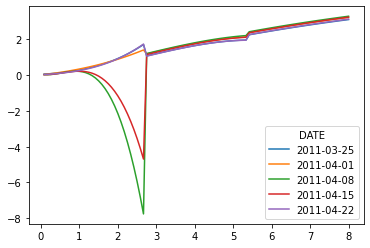

In [6]:
df.head().T.plot()

#### 2. 1.2 Nelson Siegel Methods

For Nelson Siegel, we have all 11 data points for one model with the formula
<div class="math">
\begin{equation}
  \beta_0+\beta_1\frac{1-e^{\frac{-t}{\tau}}}{\frac{t}{\tau}}+\beta_2(\frac{1-e^{\frac{-t}{\tau}}}{\frac{t}{\tau}}-e^{\frac{-t}{\tau}})+\beta_3(\frac{1-e^{\frac{-t}{\tau}}}{\frac{t}{\tau}}-e^{\frac{-t}{\tau}})
\end{equation}
</div>
From the graph, we can tell that the curve is pretty smooth and fits well, therefore we prefer this method.

In [7]:
f = lambda x: Curves.SpotRateCurve(spot.columns,x)(tenor,method='NS')
df = spot.apply(f,axis=1,result_type='expand')
df.columns = tenor
df.head()

,0.083333,0.166667,0.250000,0.333333,0.416667,0.500000,0.583333,0.666667,0.750000,0.833333,...,7.250000,7.333333,7.416667,7.500000,7.583333,7.666667,7.750000,7.833333,7.916667,8.000000
DATE,,,,,,,,,,,,,,,,,,,,,
2011-03-25,0.071345,0.076548,0.084951,0.096339,0.110509,0.127269,0.146438,0.167842,0.191320,0.216715,...,2.918716,2.942891,2.966737,2.990258,3.013459,3.036343,3.058914,3.081177,3.103136,3.124794
2011-04-01,0.056119,0.067887,0.082682,0.100289,0.120502,0.143129,0.167988,0.194907,0.223722,0.254282,...,3.041788,3.065376,3.088629,3.111550,3.134145,3.156418,3.178373,3.200016,3.221351,3.242382
2011-04-08,0.027352,0.038834,0.053606,0.071427,0.092072,0.115326,0.140988,0.168868,0.198787,0.230576,...,3.107999,3.131872,3.155397,3.178578,3.201420,3.223928,3.246108,3.267964,3.289502,3.310726
2011-04-15,0.034121,0.042068,0.053425,0.067951,0.085417,0.105609,0.128324,0.153368,0.180563,0.209736,...,3.053346,3.077571,3.101449,3.124985,3.148183,3.171049,3.193587,3.215801,3.237697,3.259280
2011-04-22,0.051234,0.053485,0.059352,0.068588,0.080960,0.096246,0.114237,0.134737,0.157558,0.182525,...,2.939462,2.963724,2.987645,3.011229,3.034481,3.057406,3.080008,3.102291,3.124260,3.145919


<AxesSubplot:>

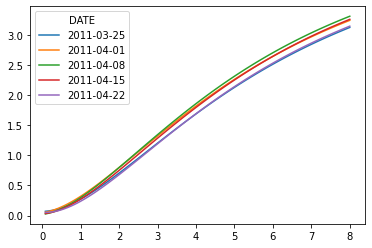

In [8]:
df.head().T.plot()

### 2.2 Annual volatility

               vol
tenor             
0.083333  0.422012
0.166667  0.273456
0.250000  0.225251
0.333333  0.205560
0.416667  0.200233


<AxesSubplot:xlabel='tenor'>

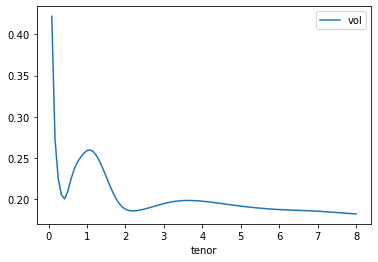

In [9]:
vol = pd.DataFrame(zip(df.columns,np.log(df[-window_len-120:-120]/df[-window_len-120:-120].shift(1)).std(axis=0)/np.sqrt(5/252)),columns=['tenor','vol'])
vol = vol.set_index('tenor')
print(vol.head())
vol.plot()

-----------
## 3. Installment 3


### 3.1 Bond Option Pricing

![model](./models.png)

#### 3.1.1 Vasicek Model

In [10]:
data = CMT
model_type = 'V'
intp = 'NS'
opt = [0.57, 6, 8]
bond = [0, 8, 8, 1]
optCall = True
step = 1 / 12
rounds = 10000
window_len = 96

pricer = IRModel.BondOptionPricer(data, model_type, intp,
                          opt, bond, optCall, step, rounds, window_len)
pricer.getOptionPrice()

      fun: 0.0002164878100280068
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.11099919e-06, -3.18001647e-06,  3.90193737e-02])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 560
      nit: 82
     njev: 140
   status: 0
  success: True
        x: array([0.04872048, 0.10268728, 0.02      ])
Vasicek model parameters are [0.04872048 0.10268728 0.02      ]
Analytic solution for bond call [0.57, 6, 8] is 0.35875977577085605
MC simulation solution for bond call [0.57, 6, 8] with parameters (12.0, 10000) is 0.35452566660795204


#### 3.1.2 BDT Model

In [11]:
# might take a little bit longer for solver
data = pd.read_csv('./data/CMT/CMT/CMT.csv')
model_type = 'BDT'
intp = 'NS'
opt = [0.57, 6, 8]
bond = [0, 8, 8, 1]
optCall = True
step = 1 / 12
rounds = 10000
window_len = 100
pricer = IRModel.BondOptionPricer(data, model_type, intp,
                          opt, bond, optCall, step, rounds, window_len)
pricer.getOptionPrice()

[[0.39205206 0.39730106 0.40274291 ... 0.43       0.43       0.43      ]
 [0.         0.38683788 0.39441719 ... 0.43       0.43       0.43      ]
 [0.         0.         0.38370072 ... 0.43       0.43       0.43      ]
 ...
 [0.         0.         0.         ... 0.43       0.43       0.43      ]
 [0.         0.         0.         ... 0.         0.43       0.43      ]
 [0.         0.         0.         ... 0.         0.         0.43      ]]


0.3920520601518496

In [12]:
pd.DataFrame(pricer.model.shortRate).to_csv('shortRateTree.csv')

### 3.2 Results Analysis

- Vasicek Model

>Analytic solution for bond call [0.57, 6, 8] is 0.35875977577085605

>MC simulation solution for bond call [0.57, 6, 8] with parameters (12.0, 10000) is 0.3569789341234479

From results, we can see analytic method and simulation method get very close solutions. It proves that our pricing model works as we expected.

- BDT model

We got a price also close to the solutions in the Vasicek Model. (0.3920520601518496)

### 3.3 Interpolation errors

Cubic Spline interpolation method tends to generate errors because of limited input points. Even with gap conditions and kink conditions, the model is still highly likely to fail. Instead, Nelson Siegel interpolation method shows much better and fitted results.

### 3.4 Selling Option Product

For hedging purpose, we do convexity hedging, namely making the hedging decision when the portfolio convexity equals to 0. We calculate DV01 by moving the yields of CMT by 1 basis point. Then through Vasicek model, we are able to calculate the corresponding price change， which is shown in below 
<div class="math">
\begin{equation}
\frac{change of prices}{change of yields * 10,000}
\end{equation}
</div>

We have DV01 for bond is 0.000712167725991919 and DV01 for option is 0.035745.

hedging strategy

- sell call option
- cash hedging, prot DV01 = 0

In [28]:
# Calculate underlying DV01
y = np.array(df.iloc[-1,:])
y1 = np.array(df.iloc[-1,:] + 0.01)
y2 = np.array(df.iloc[-1,:] - 0.01)
b = np.exp(-y[-1]/100*8)
b1 = np.exp(-y1[-1]/100*8)
b2 = np.exp(-y2[-1]/100*8)
DV01_B = (b2-b1)/2/0.0001

In [29]:
DV01_B

7.12167725991919

In [22]:
# set parameters
data = CMT
data1 = CMT
data1 = data1.applymap(lambda x: x if str(x)[-3]=='-' else x+0.01)
data2 = CMT
data2 = data2.applymap(lambda x: x if str(x)[-3]=='-' else x-0.01)
model_type = 'V'
intp = 'NS'
opt = [0.57, 6, 8]
bond = [0, 8, 8, 1]
optCall = True
step = 1 / 12
rounds = 10000
window_len = 96

pricer = IRModel.BondOptionPricer(data2, model_type, intp,
                          opt, bond, optCall, step, rounds, window_len)
pricer.getOptionPrice()
pricer = IRModel.BondOptionPricer(data1, model_type, intp,
                          opt, bond, optCall, step, rounds, window_len)
pricer.getOptionPrice()

      fun: 7.146968758846089e-07
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.82048079e-06, -1.48895202e-04,  8.54337088e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 6
     njev: 26
   status: 0
  success: True
        x: array([8.69117809e-01, 8.67792438e-04, 3.67629253e-02])
Vasicek model parameters are [8.69117809e-01 8.67792438e-04 3.67629253e-02]
Analytic solution for bond call [0.57, 6, 8] is 0.42988599293547325
MC simulation solution for bond call [0.57, 6, 8] with parameters (12.0, 10000) is 0.42981815451218974
      fun: 0.00021596937584886968
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.07850772e-06, -1.57761716e-06,  3.88171083e-02])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 468
      nit: 72
     njev: 117
   status: 0
  success: True
        x: array([0.04866436, 0.10291103, 0.02      ])
Vasicek model parameters are [0.04866436 0.

In [30]:
# option DV01
DV01_opt = (0.42989 - 0.3584)/2/0.0001; DV01_opt

357.45

In [31]:
hedge_ratio = -DV01_opt/DV01_B

In [32]:
hedge_ratio*b+0.35875977577085605

-44.32248545823014

### 3.5 Sensitivity Analysis

We selected different window length and compare: we found that shorter the better after trying i year length, 2 year length and the suggested 250 weeks, the one with the smallest bias should be the 1 year window length.

In [19]:
# might take a little bit longer for solver
model_type = 'BDT'
window_len_1 = 100
window_len_2 = 150
pricer1 = IRModel.BondOptionPricer(data, model_type, intp,
                          opt, bond, optCall, step, rounds, window_len_1)
price1 = pricer.getOptionPrice()

pricer2 = IRModel.BondOptionPricer(data, model_type, intp,
                          opt, bond, optCall, step, rounds, window_len_2)
price2 = pricer.getOptionPrice()

delta_window = (price2-price1)/50
print(delta_window)

-0.007492273248100969


The results above show that our model relative less sensitive to the vol window selection.